# Error convergence: ELM-ODE, SWIM-ODE 
In this script, we study how the error decays with the width of the neural network (and collocation points).

In [5]:
# Imports
import sys
sys.path.append('../../')
sys.path.append('../../src')
from swimpde import Domain
from swimpde import BoundaryCompliantAnsatz
from swimpde import AdvectionSolver
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import time

### Problem setup

In [6]:
# List of all hyper-parameters
n_s = np.linspace(20, 240, 10, dtype="int") # Root of mean squared error points
reg_OBF = [1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12] 
reg_pinv_ic = reg_OBF # Regularization const for pseudo-inverse and least squares solution for IC
conv_coeff = 10. # convection coefficient
ratios = [8] # data_points/outer basis functions
n_IBFs_factors = [5]

n_test = 256 # Number of test points in space
n_t = 256 # Set time domain

# Domain: 1-d space with uniform grid
x_lim = [0, 2 * np.pi]

# initial condition
def u0(x):
    return np.sin(x)

# forcing
def forcing(x, t):
    return np.zeros(x.shape[0])

# Analytical solution
def analytical_sol(x, t):
    return np.sin(x - conv_coeff * t)

### Fit SWIM-ODE and ELM-ODE

In [7]:
experiments = []
seeds = [1, 2, 3]
for n_data in n_s:
    for r in ratios: 
        for reg in reg_OBF:
            for n_i in n_IBFs_factors:
                info = []
                n_OBF = int(n_data//r) #2 # Number of outer basis functions
                n_IBF = int(n_i * n_OBF) # Number of inner basis functions
                t_eval = np.linspace(0, 1, 100)
                x_space = np.linspace(x_lim[0], x_lim[1], n_data).reshape((-1, 1))

                # interior points
                x_space_inner = x_space[1:-1]
                interior_points = x_space_inner

                # coordinates of boundary points (excluding corners)
                left = x_lim[0]
                right = x_lim[1]
                boundary_points = np.row_stack([left, right])

                # normal vectors on the boundary
                normal_vectors = boundary_points.copy()
                normal_vectors[0] = 1 #-1
                normal_vectors[1] = 1 #1

                domain = Domain(
                    interior_points=interior_points,
                    boundary_points=boundary_points,
                    normal_vectors=normal_vectors
                )

                # Set boundary conditions
                boundary_condition = "periodic"

                # Test Data
                x_space_test = np.linspace(np.min(x_space), np.max(x_space), n_test).reshape((-1, 1))
                u_true_test = analytical_sol(x_space_test, t_eval).T
                
                def periodic_outer_basis_sine(x_space, n_outer_basis=None, initial_condition=None):
                        return np.column_stack([
                            sine_cos(x_space * (i+1))
                            for i in range(n_outer_basis//2)
                            for sine_cos in [np.sin, np.cos]
                        ])
                rng = np.random.default_rng(123)
                
                def sample_parameters_randomly(x, _, rng):
                    weights = rng.normal(loc=0, scale=1, size=(x.shape[1], n_IBF))
                    biases = rng.uniform(low=-4, high=4, size=(1, n_IBF)) # low=-np.pi, high=np.pi,  2 * np.pi
                    idx0 = None
                    idx1 = None
                    return weights, biases, idx0, idx1
                
                
                # Loop over different seeds
                rmse_swim = np.ones((len(seeds), ))
                rmse_swim_rs = np.ones((len(seeds), ))
                rmse_elm = np.ones((len(seeds), ))
                rel_err_swim = np.ones((len(seeds), ))
                rel_err_swim_rs = np.ones((len(seeds), ))
                rel_err_elm = np.ones((len(seeds), ))
                time_swim = np.ones((len(seeds), ))
                time_swim_rs = np.ones((len(seeds), ))
                time_elm = np.ones((len(seeds), ))
                l2_rel_err_elm = np.ones((len(seeds), ))
                l2_rel_err_swim = np.ones((len(seeds), ))
                j = 0
                for s in seeds:
                    # ELM ansatz
                    ansatz_elm = BoundaryCompliantAnsatz(
                        n_outer_basis=n_OBF,
                        n_inner_basis=n_IBF,
                        activation="tanh",
                        target_gen=periodic_outer_basis_sine,
                        random_state=s,
                        regularization_scale=reg,
                        parameter_sampler = sample_parameters_randomly
                    )
                    # SWIM ansatz
                    ansatz_swim = BoundaryCompliantAnsatz(
                        n_outer_basis=n_OBF,
                        n_inner_basis=n_IBF,
                        activation="tanh",
                        target_gen=periodic_outer_basis_sine,
                        random_state=s,
                        regularization_scale=reg,
                    )

                    # Set advection solver
                    adv_solver_elm = AdvectionSolver(
                        domain=domain, 
                        ansatz=ansatz_elm,
                        u0=u0,
                        boundary_condition=boundary_condition,
                        c=conv_coeff,
                        forcing=forcing,
                        regularization_scale=reg,
                    )
                    adv_solver_swim = AdvectionSolver(
                        domain=domain, 
                        ansatz=ansatz_swim,
                        u0=u0,
                        boundary_condition=boundary_condition,
                        c=conv_coeff,
                        forcing=forcing,
                        regularization_scale=reg,
                    )

                    # Compute weights and biases of the SWIM network
                    time_blocks = 1
                    t_swim_start = time.time()
                    sol, solver_status = adv_solver_swim.fit(t_span=[0, np.max(t_eval)], rtol = 1e-10, atol = 1e-10, svd_cutoff=reg);
                    t_swim_stop = time.time()
                    time_swim[j] = t_swim_stop - t_swim_start
                    
                    t_elm_start = time.time()
                    adv_solver_elm.fit(t_span=[0, np.max(t_eval)], rtol = 1e-10, atol = 1e-10, svd_cutoff=reg);
                    t_elm_stop = time.time()
                    time_elm[j] = t_elm_stop - t_elm_start

                    # Evaluate solution
                    u_elm_test = adv_solver_elm.evaluate(x_eval=x_space_test, t_eval = t_eval).T
                    u_swim_test = adv_solver_swim.evaluate(x_eval=x_space_test, t_eval = t_eval).T #, solver_status=solver_status
                    
                    # Store useful info for plotting
                    mse_elm = mean_squared_error(u_true_test, u_elm_test)  # mean squared error
                    rmse_elm[j] = np.sqrt(mse_elm)  # Root Mean Squared Error
                    mse_swim = mean_squared_error(u_true_test, u_swim_test)  # mean squared error
                    rmse_swim[j] = np.sqrt(mse_swim)  # Root Mean Squared Error
                    l2_rel_err_elm[j] = np.linalg.norm(u_elm_test - u_true_test, 2)/np.linalg.norm(u_true_test, 2)
                    l2_rel_err_swim[j] = np.linalg.norm(u_swim_test - u_true_test, 2)/np.linalg.norm(u_true_test, 2)
                    j += 1

                info.append(n_data)
                info.append(int(n_data//r))
                info.append(reg)
                info.append(np.mean(time_elm))
                info.append(np.mean(time_swim))
                info.append(np.mean(rmse_elm)) # 6
                info.append(np.mean(rmse_swim))
                info.append(np.mean(rel_err_elm))
                info.append(np.mean(rel_err_swim))
                info.append(np.mean(l2_rel_err_elm))
                info.append(np.mean(l2_rel_err_swim))
                info.append(np.min(l2_rel_err_elm))
                info.append(np.min(l2_rel_err_swim))
                print("n_s=", info[0], ", n_b=", info[1], ", reg_const=", info[2])
                print("scale_bc=", info[3], ", domain_boundary_percent=", info[4])
                print("time_elm=", info[5], ", time_swim=", info[6])
                print("rmse_swim=", rmse_swim,", rmse_elm=", rmse_elm)
                print("l2_rel_err_swim=", l2_rel_err_swim,", l2_rel_err_elm=", l2_rel_err_elm)
                experiments.append(info)
                


n_s= 20 , n_b= 2 , reg_const= 1e-07
scale_bc= 0.00913381576538086 , domain_boundary_percent= 0.019352833429972332
time_elm= 0.17703488519513003 , time_swim= 0.009421308200772355
rmse_swim= [0.01172695 0.01193353 0.00460344] , rmse_elm= [0.44387499 0.04260867 0.04462099]
l2_rel_err_swim= [0.01714538 0.01846111 0.00668867] , l2_rel_err_elm= [0.66023022 0.06497527 0.06535613]
n_s= 20 , n_b= 2 , reg_const= 1e-08
scale_bc= 0.008697032928466797 , domain_boundary_percent= 0.010370175043741861
time_elm= 0.2250167677351991 , time_swim= 0.009421308200772355
rmse_swim= [0.01172695 0.01193353 0.00460344] , rmse_elm= [0.61800432 0.01217538 0.0448706 ]
l2_rel_err_swim= [0.01714538 0.01846111 0.00668867] , l2_rel_err_elm= [1.0011059  0.01708148 0.0656898 ]
n_s= 20 , n_b= 2 , reg_const= 1e-09
scale_bc= 0.009501457214355469 , domain_boundary_percent= 0.009686708450317383
time_elm= 0.07804336306573294 , time_swim= 0.009421308200772355
rmse_swim= [0.01172695 0.01193353 0.00460344] , rmse_elm= [0.13714384

### Convergence plot

[ 2  5  8 11 14 17 20 23 26 30]


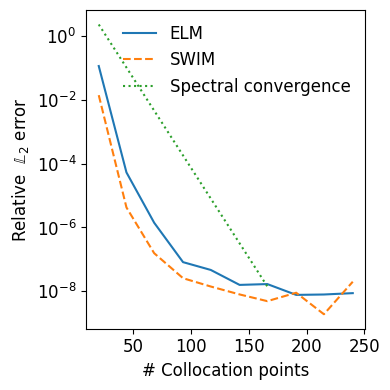

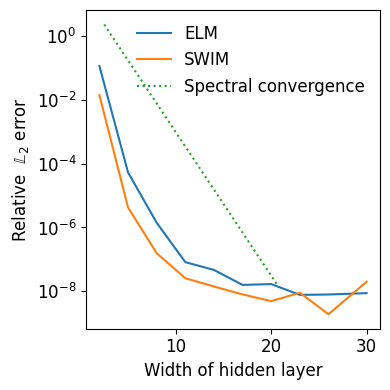

In [10]:
res = np.vstack(experiments)
rc_fonts = {
    "text.usetex": False,
}
plt.rcParams.update(rc_fonts)

# Extract the lowest mae, rmse, mse for a fixed number of collocation points
mse_elm = np.ones((len(n_s),)) * 1e100
rmse_elm = np.ones((len(n_s),)) * 1e100
mae_elm = np.ones((len(n_s),)) * 1e100
mse_swim = np.ones((len(n_s),)) * 1e100
rmse_swim = np.ones((len(n_s),)) * 1e100
mae_swim = np.ones((len(n_s),)) * 1e100
l2_rel_err_elm = np.ones((len(n_s),)) * 1e100
l2_rel_err_swim = np.ones((len(n_s),)) * 1e100
l2_rel_err_elm_min = np.ones((len(n_s),)) * 1e100
l2_rel_err_swim_min = np.ones((len(n_s),)) * 1e100
s_i = 5 # Start index
jump = len(reg_OBF) * len(ratios)
for i in range(len(n_s)):
    rmse_elm[i] = min(res[(i*jump):(i+1)*jump, s_i])
    rmse_swim[i] = min(res[(i*jump):(i+1)*jump, s_i + 1])
    l2_rel_err_elm[i] = min(res[(i*jump):(i+1)*jump, s_i + 4])
    l2_rel_err_swim[i] = min(res[(i*jump):(i+1)*jump, s_i + 5])
    l2_rel_err_elm_min[i] = min(res[(i*jump):(i+1)*jump, s_i + 6])
    l2_rel_err_swim_min[i] = min(res[(i*jump):(i+1)*jump, s_i + 7])

# Spectral convergence line
pt_1 = 0
pt_2 = 5

x1 = n_s[pt_1]
x2 = n_s[pt_2]
y1 = l2_rel_err_elm[pt_1]
y2 = l2_rel_err_elm[pt_2]

# Compute the slope and intercept of the line (y = mx + c)
m = (np.log(y2) - np.log(y1)) / (x2 - x1)  # Using log to convert to semilogy plot
c = np.log(y1) - m * x1 + 3

# Define x-values for the line
x_values = n_s[:pt_2+2] #np.linspace(x1, x2, 100)

# Calculate corresponding y-values using the equation of the line
y_values = np.exp(m * x_values + c)  # Exponentiating to revert back from log scale

fontsize = 12
n_s = np.asarray(n_s)
end_ind = len(n_s)

fig, ax = plt.subplots(1, 1, figsize=(4, 4), sharey=True)
ax = plt.gca()  # or any other way to get an axis object
ax.semilogy(n_s[:end_ind], l2_rel_err_elm[:end_ind])
ax.semilogy(n_s[:end_ind], l2_rel_err_swim[:end_ind], '--')
ax.semilogy(x_values, y_values, ':', label='Spectral convergence')# * 50
ax.legend(["ELM", "SWIM", "Spectral convergence"], frameon=False, loc='upper right', fontsize=fontsize)
ax.set_xlabel('# Collocation points', fontsize=fontsize)
ax.set_ylabel(r'Relative  ' + r'$\mathbb{L}_{2}$ ' + r'error', fontsize=fontsize)
plt.tick_params(axis='both', labelsize=fontsize)
fig.tight_layout()
plt.savefig('convergence_adv_1.pdf')

# Spectral convergence line
x1 = n_s[pt_1]/ratios[0]
x2 = n_s[pt_2]/ratios[0]
y1 = l2_rel_err_elm[pt_1]
y2 = l2_rel_err_elm[pt_2]

# Compute the slope and intercept of the line (y = mx + c)
m = (np.log(y2) - np.log(y1)) / (x2 - x1)  # Using log to convert to semilogy plot
c = np.log(y1) - m * x1 + 3

# Define x-values for the line
x_values = n_s[:pt_2+2]/ratios[0] #np.linspace(x1, x2, 100)

# Calculate corresponding y-values using the equation of the line
y_values = np.exp(m * x_values + c)  # Exponentiating to revert back from log scale

widths = n_s[:end_ind]//ratios[0]

# Plot convergence plots
fig, ax = plt.subplots(1, 1, figsize=(4, 4), sharey=True)
n_s = np.asarray(n_s)
ax.semilogy(widths, l2_rel_err_elm[:end_ind])
ax.semilogy(widths, l2_rel_err_swim[:end_ind])
ax.semilogy(x_values, y_values, ':', label='Spectral convergence')
ax.legend(["ELM", "SWIM", "Spectral convergence"], frameon=False, loc='upper right', fontsize=fontsize) 
ax.set_xlabel('Width of hidden layer', fontsize=fontsize)
ax.set_ylabel(r'Relative  ' + r'$\mathbb{L}_{2}$ ' + r'error', fontsize=fontsize)
plt.tick_params(axis='both', labelsize=fontsize)
fig.tight_layout()
plt.savefig('convergence_adv_2.pdf')

# Uncomment the following to store the arrays for plotting
# with open('adv_rel_err_width.npy', 'wb') as f:
#    np.save(f, np.vstack((widths, l2_rel_err_elm[:end_ind], l2_rel_err_swim[:end_ind])))

# Store the arrays for plotting
# with open('adv_rel_err_coll_points.npy', 'wb') as f:
#     np.save(f, np.vstack((n_s[:end_ind], l2_rel_err_elm[:end_ind], l2_rel_err_swim[:end_ind])))